# Forecasting Series

https://www.kaggle.com/datasets/veronicataipe/barcelona-atmosphere-data

In [5]:
#First steep is import the libraries. 
import tensorflow as tf
tf.random.set_seed(42)
from sklearn.model_selection import train_test_split
#Numpy is a lybrary that allow us to work with arrays. 
import numpy as np
#keras is an open source neural networks lybrary writted in python that run's in varios frameworks, TensorFlow included. 
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
import pandas as pd
import csv


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import linregress

#Tranfer learning from tensorhub
import tensorflow_hub as hub

print (tf.__version__)

gEpochs = 10
WINDOW_SIZE = 5

2.9.0


In [26]:
# Get the data from the df. 
bcntmp = './Data/BCNtemp.csv'
df = pd.read_csv(bcntmp)


In [27]:
# YEAR, MO, DY, HR, PS, T2M
df_work = df[["YEAR", "MO", "DY", "HR", "PS", "T2M"]]
df_work

,YEAR,MO,DY,HR,PS,T2M
0,2001,1,1,0,97.95,3.49
1,2001,1,1,1,97.89,3.65
2,2001,1,1,2,97.82,3.41
3,2001,1,1,3,97.76,3.55
4,2001,1,1,4,97.71,3.92
...,...,...,...,...,...,...
184075,2021,12,31,19,99.14,12.30
184076,2021,12,31,20,99.15,12.08
184077,2021,12,31,21,99.15,11.65
184078,2021,12,31,22,99.14,11.52


In [28]:
df_work.dtypes

YEAR      int64
MO        int64
DY        int64
HR        int64
PS      float64
T2M     float64
dtype: object

## Create Datetime in seconds

In [29]:
df_work["DateTime"] = df_work["YEAR"].apply(str) +"-"+ df_work["MO"].apply(str) +"-"+ df_work["DY"].apply(str) +" "+ df_work["HR"].apply(str)+":0:0"

/var/folders/2_/2936w91502s198v13fcwhz9w0000gn/T/ipykernel_10096/1348947142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work["DateTime"] = df_work["YEAR"].apply(str) +"-"+ df_work["MO"].apply(str) +"-"+ df_work["DY"].apply(str) +" "+ df_work["HR"].apply(str)+":0:0"


In [30]:
df_work.head()

,YEAR,MO,DY,HR,PS,T2M,DateTime
0,2001,1,1,0,97.95,3.49,2001-1-1 0:0:0
1,2001,1,1,1,97.89,3.65,2001-1-1 1:0:0
2,2001,1,1,2,97.82,3.41,2001-1-1 2:0:0
3,2001,1,1,3,97.76,3.55,2001-1-1 3:0:0
4,2001,1,1,4,97.71,3.92,2001-1-1 4:0:0


In [31]:
df_work.index = pd.to_datetime(df_work["DateTime"], format="%Y-%m-%d %H")
df_work[:6]

,YEAR,MO,DY,HR,PS,T2M,DateTime
DateTime,,,,,,,
2001-01-01 00:00:00,2001,1,1,0,97.95,3.49,2001-1-1 0:0:0
2001-01-01 01:00:00,2001,1,1,1,97.89,3.65,2001-1-1 1:0:0
2001-01-01 02:00:00,2001,1,1,2,97.82,3.41,2001-1-1 2:0:0
2001-01-01 03:00:00,2001,1,1,3,97.76,3.55,2001-1-1 3:0:0
2001-01-01 04:00:00,2001,1,1,4,97.71,3.92,2001-1-1 4:0:0
2001-01-01 05:00:00,2001,1,1,5,97.69,4.28,2001-1-1 5:0:0


## Interpreting Day and Year cycles
The temperature has two clear cycles, one is in the day ant the other in year. We are going to use the sin & cos seconds in the and in year to help interpret how this cycles affect to the forecasting.

In [32]:

df_work['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)

/var/folders/2_/2936w91502s198v13fcwhz9w0000gn/T/ipykernel_10096/3285392409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)


In [42]:
df_work[70120:70130]

,PS,T2M,Seconds,Day sin,Day cos,Year sin,Year cos
DateTime,,,,,,,
2008-12-31 16:00:00,98.70,9.65,1.230739e+09,-8.660254e-01,-5.000000e-01,0.003598,0.999994
2008-12-31 17:00:00,98.71,9.38,1.230743e+09,-9.659258e-01,-2.588190e-01,0.004315,0.999991
2008-12-31 18:00:00,98.72,9.60,1.230746e+09,-1.000000e+00,7.867334e-13,0.005032,0.999987
2008-12-31 19:00:00,98.72,9.67,1.230750e+09,-9.659258e-01,2.588190e-01,0.005749,0.999983
2008-12-31 20:00:00,98.71,9.01,1.230754e+09,-8.660254e-01,5.000000e-01,0.006465,0.999979
2008-12-31 21:00:00,98.71,8.40,1.230757e+09,-7.071068e-01,7.071068e-01,0.007182,0.999974
2008-12-31 22:00:00,98.70,7.55,1.230761e+09,-5.000000e-01,8.660254e-01,0.007899,0.999969
2008-12-31 23:00:00,98.63,6.96,1.230764e+09,-2.588190e-01,9.659258e-01,0.008616,0.999963
2009-01-01 00:00:00,98.56,6.83,1.230768e+09,-1.776611e-12,1.000000e+00,0.009332,0.999956


In [37]:
df_work.drop(["DateTime", "YEAR", "MO", "DY", "HR"], axis=1, inplace=True)

/var/folders/2_/2936w91502s198v13fcwhz9w0000gn/T/ipykernel_10096/843378061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work.drop(["DateTime", "YEAR", "MO", "DY", "HR"], axis=1, inplace=True)


In [40]:
day = 60*60*24
year = 365.2425*day

df_work['Day sin'] = np.sin(df_work['Seconds'] * (2* np.pi / day))
df_work['Day cos'] = np.cos(df_work['Seconds'] * (2 * np.pi / day))
df_work['Year sin'] = np.sin(df_work['Seconds'] * (2 * np.pi / year))
df_work['Year cos'] = np.cos(df_work['Seconds'] * (2 * np.pi / year))
df_work[70120:70130]

/var/folders/2_/2936w91502s198v13fcwhz9w0000gn/T/ipykernel_10096/542989612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work['Day sin'] = np.sin(df_work['Seconds'] * (2* np.pi / day))
/var/folders/2_/2936w91502s198v13fcwhz9w0000gn/T/ipykernel_10096/542989612.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work['Day cos'] = np.cos(df_work['Seconds'] * (2 * np.pi / day))
/var/folders/2_/2936w91502s198v13fcwhz9w0000gn/T/ipykernel_10096/542989612.py:6: SettingWithCopyWarning: 
A value is trying

,PS,T2M,Seconds,Day sin,Day cos,Year sin,Year cos
DateTime,,,,,,,
2001-01-01 00:00:00,97.95,3.49,978307200.0,-3.803622e-12,1.000000,0.008300,0.999966
2001-01-01 01:00:00,97.89,3.65,978310800.0,2.588190e-01,0.965926,0.009017,0.999959
2001-01-01 02:00:00,97.82,3.41,978314400.0,5.000000e-01,0.866025,0.009734,0.999953
2001-01-01 03:00:00,97.76,3.55,978318000.0,7.071068e-01,0.707107,0.010450,0.999945
2001-01-01 04:00:00,97.71,3.92,978321600.0,8.660254e-01,0.500000,0.011167,0.999938


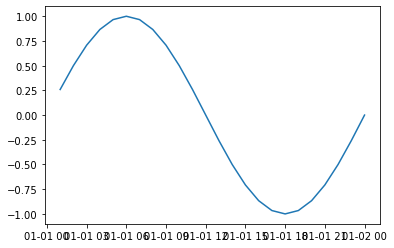

In [72]:
plt.plot(df_work["Day sin"][1:25])

In [57]:
df_work.drop(["Seconds"], inplace=True, axis = 1)
df_work.head()

,PS,T2M,Day sin,Day cos,Year sin,Year cos
DateTime,,,,,,
2001-01-01 00:00:00,97.95,3.49,-3.803622e-12,1.000000,0.008300,0.999966
2001-01-01 01:00:00,97.89,3.65,2.588190e-01,0.965926,0.009017,0.999959
2001-01-01 02:00:00,97.82,3.41,5.000000e-01,0.866025,0.009734,0.999953
2001-01-01 03:00:00,97.76,3.55,7.071068e-01,0.707107,0.010450,0.999945
2001-01-01 04:00:00,97.71,3.92,8.660254e-01,0.500000,0.011167,0.999938


In [47]:
#Put the data in a X and y arrays
#We get a number of datas to predict the next one. In case of a window_size of 5
#The shape change to accept multivariate variables, the most important variable comes first. 
#First round x[[t0, ds0, ..., yc0] [t1, ds1, ..., yc1] ...[t4, ds4, ..., yc4]] y[t5][p5]
#First round x[[t1, ds1, ..., yc1] [t2, ds2, ..., yc2] ...[t5, ds5, ..., yc5]] y[t6][p6]
#.... till the end of serie. 
def df_xy_series(df, window_size=WINDOW_SIZE, label1=4, label2=5):
    #Convert dataset to Numpy
    df_as_np = df.to_numpy()
    X=[]
    y=[]
    
    for i in range(len(df_as_np)-window_size):
        #ADDINg AN ENTIRE ROW
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        #add the 2 labels. 
        label = df_as_np[i+window_size][label1], df_as_np[i+window_size][label2]
        y.append(label)
    
    return np.array(X), np.array(y)

In [61]:
X, y = df_xy_series(df_work, label1=0, label2=1)
X.shape, y.shape, y[0]

((184075, 5, 6), (184075, 2), array([97.69,  4.28]))

In [62]:
#Split the data 
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
#X_train.shape, X_val.shape, y_train.shape, y_val.shape 

X_train, y_train = X[:150000], y[:150000]
X_val, y_val = X[150000:], y[150000:]
X_train.shape, X_val.shape, y_train.shape, y_val.shape 

((150000, 5, 6), (34075, 5, 6), (150000, 2), (34075, 2))

In [10]:
#Standarize the input training data
def preprocess_X(X, cols=[0]):
    for n in cols: 
        mean = np.mean(X[:, :, n])
        std = np.std(X[:, :, n])
        X[:, :, n] = (X[:, :, n] - mean) / std
        print ("trreating col X {n}",  n)
    return X
        
def preprocess_y(y, cols=[0]):
    for n in cols: 
        mean = np.mean(y[ :, n])
        std = np.std(y[:, n])
        y[:, n] = (y[:, n] - mean) / std
        print ("treating col y {n}",  n)
    return y

In [11]:

#X_train = preprocess_X (X_train, cols=[0, 1, 2, 3, 5])


In [63]:
y_train[0]

array([97.69,  4.28])

In [14]:
#y_train = preprocess_y(y_train, [0, 1])

In [15]:
y_train[0]

array([97.69,  4.28])

In [64]:
# Define different models
def get_model(kindmodel, varsInput = 1, window_size = WINDOW_SIZE):
    switcher = {
        #LSTM Bidirectionsl
        12:tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                     strides=1,
                     activation="relu",
                     padding='causal',
                     input_shape=[window_size, varsInput]),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(8, activation="relu"),
            tf.keras.layers.Dense(4, activation="relu"),
            tf.keras.layers.Dense(2)]),
        #convolutiona + Maxpooling
        2:tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=64, kernel_size=2,
                     activation="relu",
                     input_shape=[window_size, varsInput]), 
            tf.keras.layers.MaxPooling1D(pool_size=2), 
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(8, activation='relu'), 
            tf.keras.layers.Dense(2)]), 
        #Input Layer LSTM
        3:tf.keras.models.Sequential([
            tf.keras.layers.InputLayer((window_size, varsInput)), 
            tf.keras.layers.LSTM(64), 
            tf.keras.layers.Dense(8, activation='relu'), 
            tf.keras.layers.Dense(2, activation="linear")]), 
        4:tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                     strides=1,
                     activation="relu",
                     padding='causal',
                     input_shape=[window_size, varsInput]),
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(8, activation="relu"),
            tf.keras.layers.Dense(2)]),
    }
    return switcher.get(kindmodel, None)

In [65]:
model12 = get_model(3, varsInput = 6)
model12.summary()
cp12 = ModelCheckpoint('model12/', save_best_only=True)
try:
    model12.predict(X_train)
except:
    print("Architecture and dataset incompatible")
else:
    print("compatible! Congrats!")

Metal device set to: Apple M1 Pro


2022-08-08 11:16:46.087059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-08 11:16:46.087197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
 dense_6 (Dense)             (None, 2)                 18        
                                                                 
Total params: 18,714
Trainable params: 18,714
Non-trainable params: 0
_________________________________________________________________


2022-08-08 11:16:46.813280: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-08 11:16:46.950536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:16:46.988424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4688/4688 [==============================] - 11s 2ms/step
compatible! Congrats!


In [66]:
model12.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer="Adam", metrics=[RootMeanSquaredError()])
model12.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=gEpochs, callbacks=[cp12])

Epoch 1/10


2022-08-08 11:17:04.542708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:17:04.649283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:17:05.254320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4688/4688 [==============================] - ETA: 0s - loss: 236.6273 - root_mean_squared_error: 15.3827

2022-08-08 11:17:39.667841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:17:39.709049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


4688/4688 [==============================] - 43s 9ms/step - loss: 236.6273 - root_mean_squared_error: 15.3827 - val_loss: 0.3410 - val_root_mean_squared_error: 0.5840
Epoch 2/10
4684/4688 [============================>.] - ETA: 0s - loss: 0.2033 - root_mean_squared_error: 0.4509

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


4688/4688 [==============================] - 41s 9ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509 - val_loss: 0.2655 - val_root_mean_squared_error: 0.5153
Epoch 3/10
4686/4688 [============================>.] - ETA: 0s - loss: 0.1402 - root_mean_squared_error: 0.3745

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


4688/4688 [==============================] - 40s 9ms/step - loss: 0.1402 - root_mean_squared_error: 0.3745 - val_loss: 0.1317 - val_root_mean_squared_error: 0.3629
Epoch 4/10
4682/4688 [============================>.] - ETA: 0s - loss: 0.1252 - root_mean_squared_error: 0.3538

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


4688/4688 [==============================] - 40s 9ms/step - loss: 0.1252 - root_mean_squared_error: 0.3538 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3457
Epoch 5/10
4682/4688 [============================>.] - ETA: 0s - loss: 0.1146 - root_mean_squared_error: 0.3386

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


4688/4688 [==============================] - 41s 9ms/step - loss: 0.1146 - root_mean_squared_error: 0.3386 - val_loss: 0.0908 - val_root_mean_squared_error: 0.3013
Epoch 6/10
4684/4688 [============================>.] - ETA: 0s - loss: 0.1032 - root_mean_squared_error: 0.3213

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


4688/4688 [==============================] - 41s 9ms/step - loss: 0.1032 - root_mean_squared_error: 0.3213 - val_loss: 0.0904 - val_root_mean_squared_error: 0.3007
Epoch 7/10
4685/4688 [============================>.] - ETA: 0s - loss: 0.0912 - root_mean_squared_error: 0.3019

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


4688/4688 [==============================] - 41s 9ms/step - loss: 0.0912 - root_mean_squared_error: 0.3019 - val_loss: 0.0856 - val_root_mean_squared_error: 0.2925
Epoch 8/10
4685/4688 [============================>.] - ETA: 0s - loss: 0.0859 - root_mean_squared_error: 0.2931

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


4688/4688 [==============================] - 41s 9ms/step - loss: 0.0859 - root_mean_squared_error: 0.2931 - val_loss: 0.0696 - val_root_mean_squared_error: 0.2639
Epoch 9/10
4683/4688 [============================>.] - ETA: 0s - loss: 0.0825 - root_mean_squared_error: 0.2872

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


4688/4688 [==============================] - 41s 9ms/step - loss: 0.0825 - root_mean_squared_error: 0.2872 - val_loss: 0.0663 - val_root_mean_squared_error: 0.2575
Epoch 10/10
4688/4688 [==============================] - 38s 8ms/step - loss: 0.0809 - root_mean_squared_error: 0.2844 - val_loss: 0.0964 - val_root_mean_squared_error: 0.3105


In [73]:
def get_predictions(model, X, y):
    predictions=model.predict(X)
    
    p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
    p_actuals, temp_actuals = y[:, 0], y[:, 1]
    results = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                            'Temperature Actuals':temp_actuals,
                            'Pressure Predictions': p_preds,
                            'Pressure Actuals': p_actuals
                            })
    return predictions, results


In [74]:
train_predictions, train_results= get_predictions(
    model12, X_val, y_val)
train_results

  36/1065 [>.............................] - ETA: 3s

2022-08-08 11:26:57.211877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:26:57.248407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1065/1065 [==============================] - 3s 2ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,2.710590,3.05,98.358055,98.09
1,2.901651,2.94,98.423820,98.10
2,3.884439,3.63,98.472946,98.11
3,5.463882,5.87,98.465164,98.10
4,7.954113,7.76,98.388802,98.09
...,...,...,...,...
34070,12.225891,12.30,99.395096,99.14
34071,11.454674,12.08,99.291023,99.15
34072,11.600885,11.65,99.269768,99.15
34073,11.156206,11.52,99.341774,99.14


In [80]:
X_val[0:2]

array([[[ 9.82100000e+01,  2.56000000e+00, -7.72746244e-13,
          1.00000000e+00,  6.52975776e-01,  7.57378793e-01],
        [ 9.82000000e+01,  2.59000000e+00,  2.58819045e-01,
          9.65925826e-01,  6.53518484e-01,  7.56910557e-01],
        [ 9.81500000e+01,  2.80000000e+00,  5.00000000e-01,
          8.66025404e-01,  6.54060856e-01,  7.56441932e-01],
        [ 9.81200000e+01,  2.87000000e+00,  7.07106781e-01,
          7.07106781e-01,  6.54602892e-01,  7.55972919e-01],
        [ 9.81000000e+01,  2.98000000e+00,  8.66025404e-01,
          5.00000000e-01,  6.55144592e-01,  7.55503517e-01]],

       [[ 9.82000000e+01,  2.59000000e+00,  2.58819045e-01,
          9.65925826e-01,  6.53518484e-01,  7.56910557e-01],
        [ 9.81500000e+01,  2.80000000e+00,  5.00000000e-01,
          8.66025404e-01,  6.54060856e-01,  7.56441932e-01],
        [ 9.81200000e+01,  2.87000000e+00,  7.07106781e-01,
          7.07106781e-01,  6.54602892e-01,  7.55972919e-01],
        [ 9.81000000e+01,  2.9

In [77]:
model12_loaded = load_model("model12/")
train_predictions, train_results= get_predictions(
    model12_loaded, X_val, y_val)
train_results

  35/1065 [..............................] - ETA: 3s

2022-08-08 11:30:23.451025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 11:30:23.488203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1065/1065 [==============================] - 3s 2ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,3.056206,3.05,97.956696,98.09
1,3.133051,2.94,98.009903,98.10
2,4.140516,3.63,98.097557,98.11
3,5.724811,5.87,98.093536,98.10
4,8.149052,7.76,98.042885,98.09
...,...,...,...,...
34070,12.296421,12.30,99.053001,99.14
34071,11.552103,12.08,98.967926,99.15
34072,11.683060,11.65,98.915634,99.15
34073,11.214109,11.52,98.965271,99.14


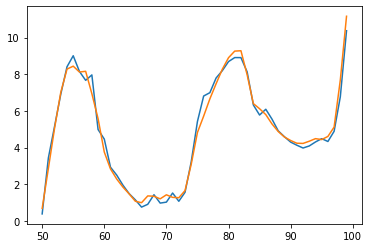

In [78]:
plt.plot(train_results['Temperature Predictions'][50:100])
plt.plot(train_results['Temperature Actuals'][50:100])